# **COVID-19 chest xray**
____________________________________________________________________
____________________________________________________________________
____________________________________________________________________

### Objective: Can we detect COVID-19 from chest X-rays?

In [ ]:
!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

Data Understanding

In [ ]:
import kagglehub

path = kagglehub.dataset_download("bachrr/covid-chest-xray")

print("Path to dataset files:", path)

100%|██████████| 241M/241M [00:01<00:00, 158MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4


In [ ]:
import kagglehub

path = kagglehub.dataset_download("bachrr/covid-chest-xray")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/covid-chest-xray


In [ ]:
metadata_path = "/kaggle/input/covid-chest-xray/metadata.csv"
df = pd.read_csv(metadata_path)
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [ ]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               372 non-null    int64  
 1   offset                  276 non-null    float64
 2   sex                     329 non-null    object 
 3   age                     318 non-null    float64
 4   finding                 372 non-null    object 
 5   survival                116 non-null    object 
 6   intubated               72 non-null     object 
 7   intubation_present      77 non-null     object 
 8   went_icu                35 non-null     object 
 9   in_icu                  7 non-null      object 
 10  needed_supplemental_O2  12 non-null     object 
 11  extubated               23 non-null     object 
 12  temperature             35 non-null     float64
 13  pO2_saturation          44 non-null     float64
 14  leukocyte_count         11 non-null     fl

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
count,372.000000,276.000000,329,318.000000,372,116,72,77,35,7,...,291,254,372,372,104,372,206,362,234,4
unique,NaN,NaN,2,NaN,11,2,2,2,2,2,...,63,55,2,372,32,179,7,287,103,3
top,NaN,NaN,M,NaN,COVID-19,Y,Y,N,Y,Y,...,2020,Italy,images,covid-19-pneumonia-progression-and-regression-...,10.1148/rg.242035193,https://pubs.rsna.org/doi/10.1148/rg.242035193,CC BY-NC-SA,Small consolidation in right upper lobe and gr...,Credit to UOC Radiology ASST Bergamo Est Direc...,"Case courtesy of Dr Edgar Lorente, Radiopaedia..."
freq,NaN,NaN,211,NaN,296,89,62,39,32,4,...,149,66,351,1,11,11,149,5,10,2
mean,100.362903,6.641304,NaN,55.993711,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,62.066915,7.155288,NaN,15.779233,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,-5.000000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,42.750000,2.000000,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,96.500000,5.000000,NaN,56.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,159.250000,9.000000,NaN,70.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df[df['modality'] == 'X-ray']
print(f"Filtered dataset size: {len(df)} images")

Filtered dataset size: 328 images


In [ ]:
df['label'] = df['finding'].apply(lambda x: 1 if 'COVID-19' in x else 0)
df['label'].value_counts()

,count
label,
1,265
0,63


In [ ]:
image_dir = "/kaggle/input/covid-chest-xray/images"
print("Example image filenames:", df['filename'].head().tolist())

Example image filenames: ['auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'nejmc2001573_f1a.jpeg']


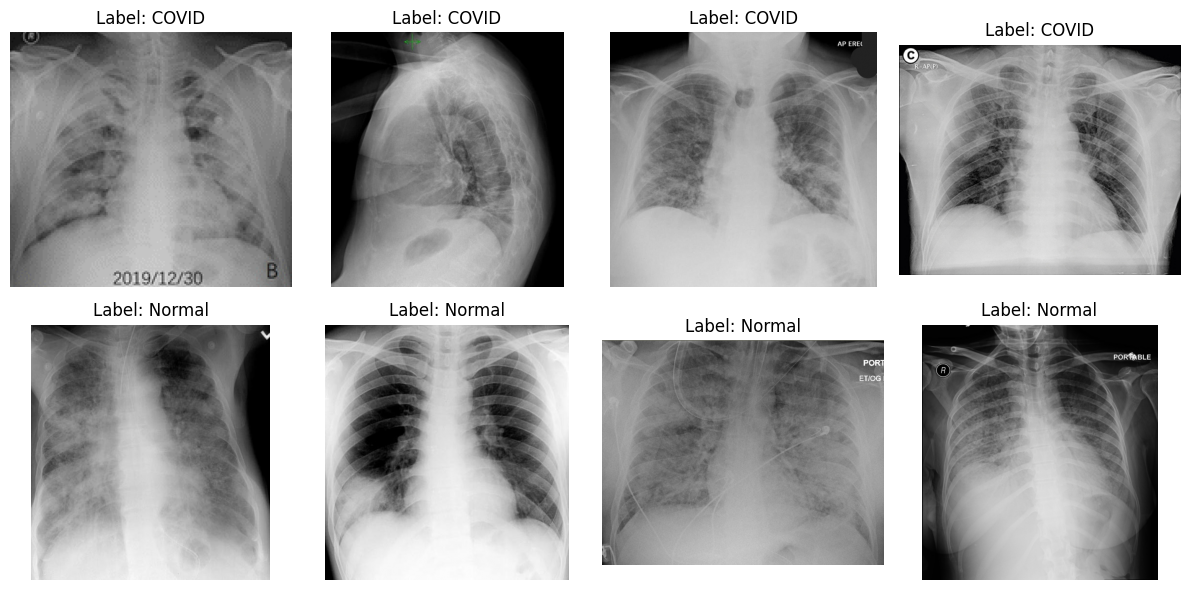

In [ ]:
from PIL import Image

covid_samples = df[df['label'] == 1].sample(4, random_state=42)
non_covid_samples = df[df['label'] == 0].sample(4, random_state=42)

sample_df = pd.concat([covid_samples, non_covid_samples])

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
    img_path = os.path.join(image_dir, row['filename'])
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {'COVID' if row['label'] == 1 else 'Normal'}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Exploratory Data Analysis

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
metadata_path = "/kaggle/input/covid-chest-xray/metadata.csv"
df = pd.read_csv(metadata_path)

print(f"Original dataset size: {len(df)} entries")
df.head()

Original dataset size: 372 entries


,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [18]:
import os
from PIL import Image

sns.set(style="whitegrid")

metadata_path = "/kaggle/input/covid-chest-xray/metadata.csv"
image_dir = "/kaggle/input/covid-chest-xray/images"

df = pd.read_csv(metadata_path)
print(f"Original dataset size: {len(df)} entries")

df = df[df['modality'] == 'X-ray'].copy()
print(f"Filtered dataset size: {len(df)} X-ray images")

df['label'] = df['finding'].apply(lambda x: 1 if 'COVID-19' in x else 0)

Original dataset size: 372 entries
Filtered dataset size: 328 X-ray images


PreProcessing

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
df['label_str'] = df['label'].map({1: "COVID-19", 0: "Non-COVID"})
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (test_ratio + val_ratio)), stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label_str',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Train: 229, Val: 49, Test: 50
Found 229 validated image filenames belonging to 2 classes.
Found 49 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Train the model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6346 - loss: 0.7052

8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6397 - loss: 0.7035 - val_accuracy: 0.7959 - val_loss: 0.4853
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7815 - loss: 0.5984 - val_accuracy: 0.7959 - val_loss: 0.4815
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7598 - loss: 0.5680 - val_accuracy: 0.7959 - val_loss: 0.4789
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7620 - loss: 0.5973 - val_accuracy: 0.7959 - val_loss: 0.4756
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7436 - loss: 0.6387 - val_accuracy: 0.7755 - val_loss: 0.4780
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7962 - loss: 0.4287 - val_accuracy: 0.7755 - val_loss: 0.4688
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7989 - loss: 0.4693 - val_accuracy: 0.7959 - val_loss: 0.4695
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8019 - loss: 0.4873 - val_accuracy: 0.7959 - val_loss: 0.4760
Epoch 9/15
8/8 ━━━━

In [26]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.7937 - loss: 0.4964
Test Accuracy: 0.8000
Test Loss: 0.4969


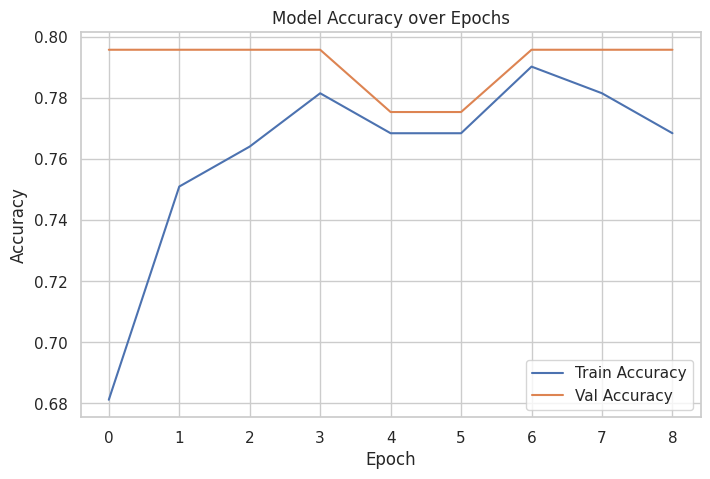

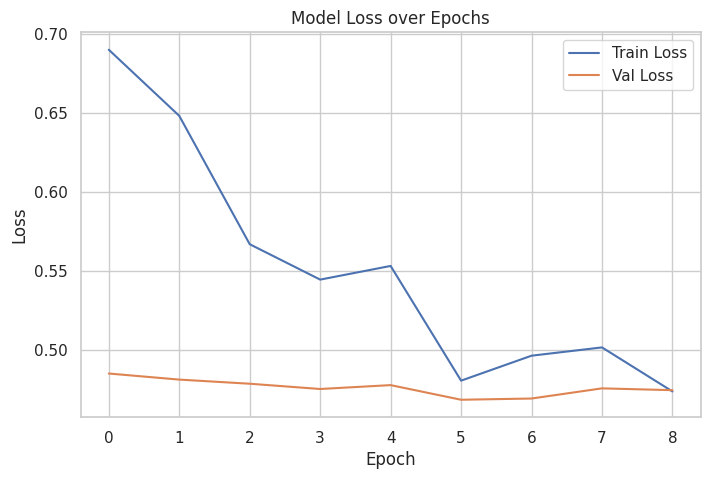

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plots

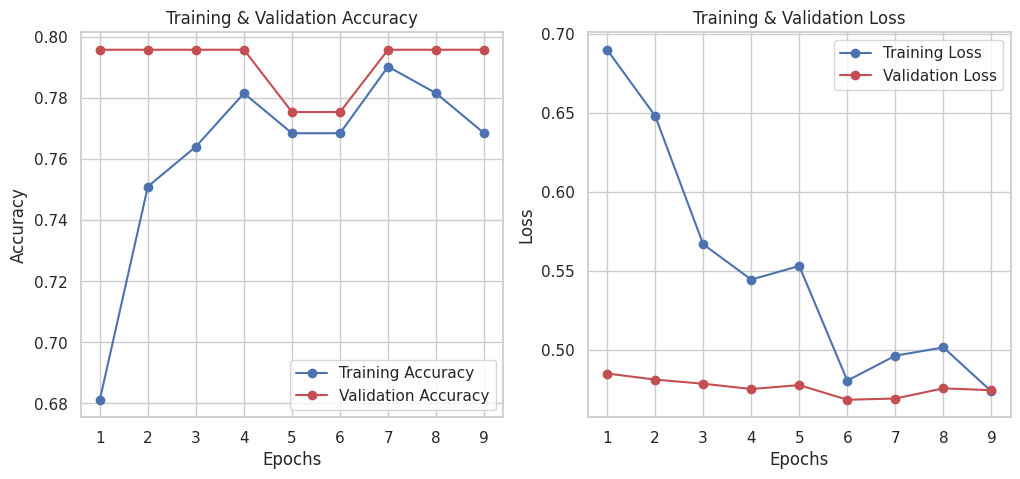

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_curves(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


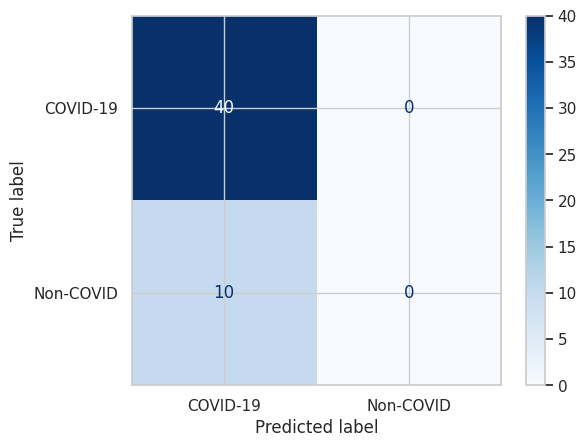

In [29]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(test_generator.classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
from tensorflow.keras.optimizers import Adam
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8318 - loss: 0.4772 - val_accuracy: 0.7755 - val_loss: 0.4693
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8088 - loss: 0.5277 - val_accuracy: 0.7959 - val_loss: 0.4750
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7930 - loss: 0.5267 - val_accuracy: 0.7755 - val_loss: 0.4810
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7955 - loss: 0.5161 - val_accuracy: 0.7755 - val_loss: 0.4874
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8020 - loss: 0.5044 - val_accuracy: 0.7959 - val_loss: 0.4935


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


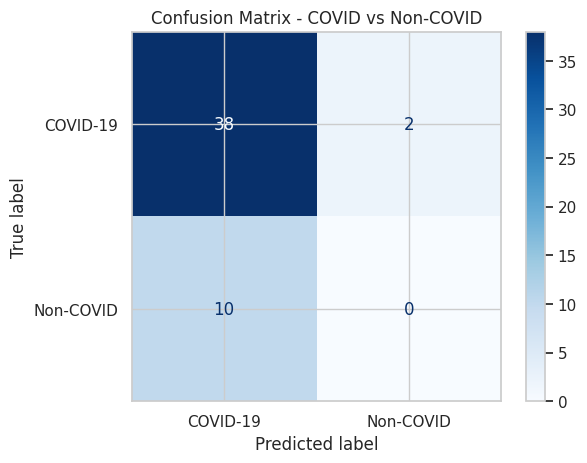

Confusion Matrix:
 [[38  2]
 [10  0]]


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype("int32")

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - COVID vs Non-COVID")
plt.show()

print("Confusion Matrix:\n", cm)

In [32]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])  # assuming 0 = Non-COVID, 1 = COVID
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)

class_weights_dict = {i : class_weights[i] for i in range(len(classes))}
print("Class Weights:", class_weights_dict)

history_balanced = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights_dict
)

Class Weights: {0: np.float64(0.6189189189189189), 1: np.float64(2.602272727272727)}
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8031 - loss: 1.1266 - val_accuracy: 0.7959 - val_loss: 0.5104
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8014 - loss: 1.0439 - val_accuracy: 0.7755 - val_loss: 0.5395
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8043 - loss: 0.7383 - val_accuracy: 0.7347 - val_loss: 0.5753
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8197 - loss: 0.6875 - val_accuracy: 0.6327 - val_loss: 0.6147
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8180 - loss: 0.6775 - val_accuracy: 0.6122 - val_loss: 0.6482


In [39]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    class_weight=class_weights_dict
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.8069 - loss: 0.4677 - val_accuracy: 0.6327 - val_loss: 0.6340
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8083 - loss: 0.5438 - val_accuracy: 0.6327 - val_loss: 0.6269
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8407 - loss: 0.5066 - val_accuracy: 0.6327 - val_loss: 0.6188
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8497 - loss: 0.5255 - val_accuracy: 0.6327 - val_loss: 0.6178
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7788 - loss: 0.5659 - val_accuracy: 0.6327 - val_loss: 0.6153


In [42]:
train_dir = "/kaggle/working/dataset/train"
val_dir   = "/kaggle/working/dataset/val"
test_dir  = "/kaggle/working/dataset/test"

In [43]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7302 - loss: 0.5021 - val_accuracy: 0.6327 - val_loss: 0.6095
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8407 - loss: 0.4119 - val_accuracy: 0.6735 - val_loss: 0.5933
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8578 - loss: 0.3711 - val_accuracy: 0.6735 - val_loss: 0.5806
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8459 - loss: 0.3658 - val_accuracy: 0.6735 - val_loss: 0.5783
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8278 - loss: 0.4192 - val_accuracy: 0.6939 - val_loss: 0.5711
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step - accuracy: 0.7167 - loss: 0.5856
Test Accuracy: 0.7000
Test Loss: 0.5961


In [45]:
train_dir = "/kaggle/working/dataset/train"

In [46]:
import os
import shutil
from sklearn.model_selection import train_test_split

metadata_path = "/kaggle/input/covid-chest-xray/metadata.csv"
images_path = "/kaggle/input/covid-chest-xray/images"
base_dir = "/kaggle/working/dataset"

df = pd.read_csv(metadata_path)
df['label'] = df['finding'].apply(lambda x: 1 if 'COVID' in str(x) else 0)

filenames = df['filename'].values
labels = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(filenames, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

for split in ['train', 'val', 'test']:
    for category in ['covid', 'non-covid']:
        create_dir(os.path.join(base_dir, split, category))

def copy_files(file_list, label_list, split_name):
    for fname, label in zip(file_list, label_list):
        src = os.path.join(images_path, fname)
        if os.path.exists(src):
            if label == 1:
                dst = os.path.join(base_dir, split_name, "covid", fname)
            else:
                dst = os.path.join(base_dir, split_name, "non-covid", fname)
            shutil.copy(src, dst)

copy_files(X_train, y_train, "train")
copy_files(X_val, y_val, "val")
copy_files(X_test, y_test, "test")

print("Data successfully split and saved.")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Data successfully split and saved.
Train: 260, Val: 56, Test: 56


In [47]:
train_dir = "/kaggle/working/dataset/train"
val_dir   = "/kaggle/working/dataset/val"
test_dir  = "/kaggle/working/dataset/test"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 249 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [48]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6143 - loss: 0.7571 - val_accuracy: 0.8269 - val_loss: 0.5116
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8123 - loss: 0.4945 - val_accuracy: 0.8269 - val_loss: 0.5251
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8251 - loss: 0.5390 - val_accuracy: 0.8269 - val_loss: 0.4946
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7561 - loss: 0.6025 - val_accuracy: 0.8269 - val_loss: 0.4750
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8103 - loss: 0.5465 - val_accuracy: 0.8269 - val_loss: 0.4691
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7910 - loss: 0.5018 - val_accuracy: 0.8269 - val_loss: 0.4637
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8150 - loss: 0.4462 - val_accuracy: 0.8269 - val_loss: 0.4618
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8106 - loss: 0.4914 - val_accuracy: 0.8269 - val_loss: 0.4620
Epoch 9/

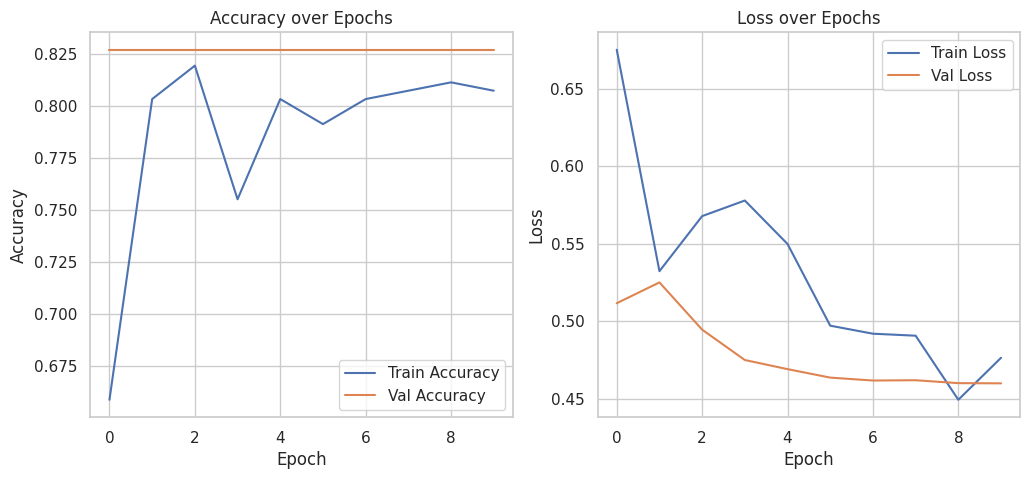

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


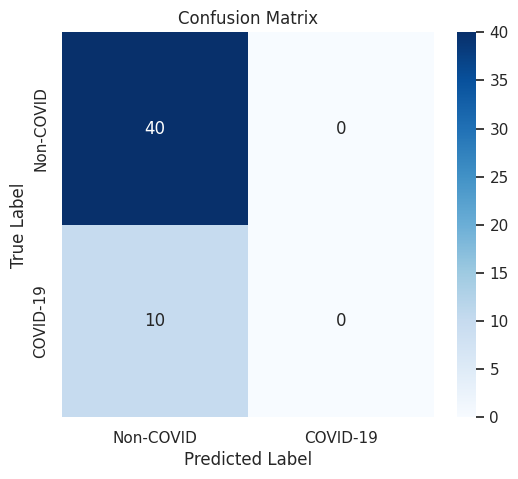

Classification Report:
              precision    recall  f1-score   support

   Non-COVID       0.80      1.00      0.89        40
    COVID-19       0.00      0.00      0.00        10

    accuracy                           0.80        50
   macro avg       0.40      0.50      0.44        50
weighted avg       0.64      0.80      0.71        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_preds = model.predict(test_generator)
test_preds_labels = (test_preds > 0.5).astype(int)

true_labels = test_generator.classes

cm = confusion_matrix(true_labels, test_preds_labels)
labels = ['Non-COVID', 'COVID-19']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, test_preds_labels, target_names=labels))

Efficent

In [51]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os

train_dir = '/kaggle/working/dataset/train'
val_dir = '/kaggle/working/dataset/val'
test_dir = '/kaggle/working/dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Found 249 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5747 - loss: 0.6615 - val_accuracy: 0.8269 - val_loss: 0.5006
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.8107 - loss: 0.5065 - val_accuracy: 0.8269 - val_loss: 0.4608
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8363 - loss: 0.4616 - val_accuracy: 0.8269 - val_loss: 0.4683
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.8206 - loss: 0.4672 - val_accuracy: 0.8269 - val_loss: 0.4661
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.8204 - loss: 0.4835 - val_accuracy: 0.8269 - val_loss: 0.4619
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8113 - loss: 0.4904 - val_accuracy: 0.8269 - val_loss: 0.4608
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.8146 - loss: 0.4788 - val_accuracy: 0.8269 - val_loss: 0.4611
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7907 - loss: 0.5076 - val_accuracy: 0.8269 - val_loss: 0.4612
Epoch 9/

In [56]:
class_weights = {int(k): float(v) for k, v in {
    np.int32(0): np.float64(0.6102941176470589),
    np.int32(1): np.float64(2.7666666666666666)
}.items()}

print(class_weights)

{0: 0.6102941176470589, 1: 2.7666666666666666}


In [57]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.1506 - loss: 0.8835 - val_accuracy: 0.8269 - val_loss: 0.4610
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - accuracy: 0.1921 - loss: 0.8292 - val_accuracy: 0.8269 - val_loss: 0.4623
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.2315 - loss: 0.7595 - val_accuracy: 0.8269 - val_loss: 0.4650
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.2197 - loss: 0.7473 - val_accuracy: 0.8269 - val_loss: 0.4695
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.1910 - loss: 0.7739 - val_accuracy: 0.8269 - val_loss: 0.4757


In [58]:
from sklearn.utils import class_weight
import numpy as np

labels = train_generator.classes
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(zip(np.unique(labels), cw))


In [59]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.2188 - loss: 0.7428 - val_accuracy: 0.8269 - val_loss: 0.4825
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.2271 - loss: 0.7399 - val_accuracy: 0.8269 - val_loss: 0.4910
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.2861 - loss: 0.7097 - val_accuracy: 0.8269 - val_loss: 0.5001
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.2495 - loss: 0.7620 - val_accuracy: 0.8269 - val_loss: 0.5081
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.2625 - loss: 0.7596 - val_accuracy: 0.8269 - val_loss: 0.5156


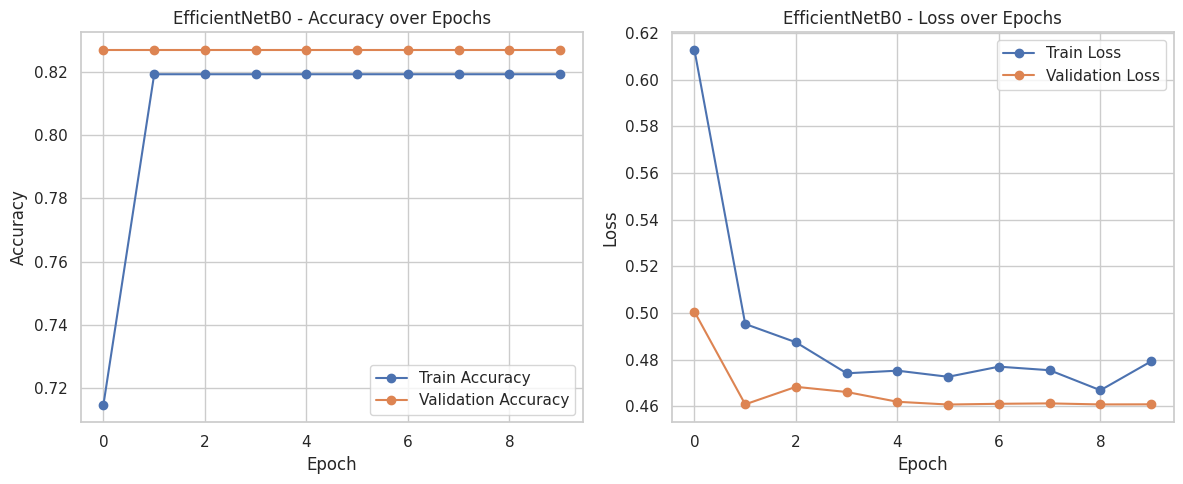

In [60]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('EfficientNetB0 - Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('EfficientNetB0 - Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


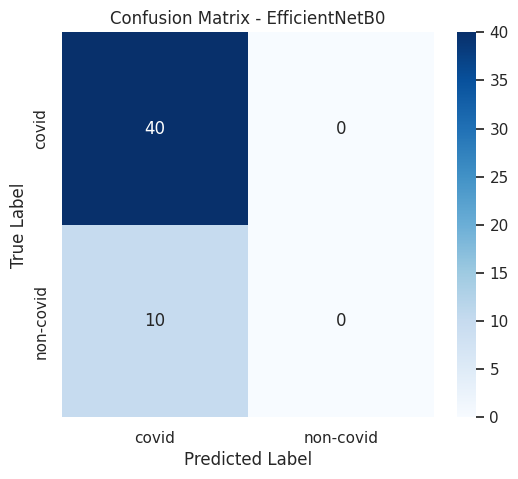

In [61]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 928ms/step


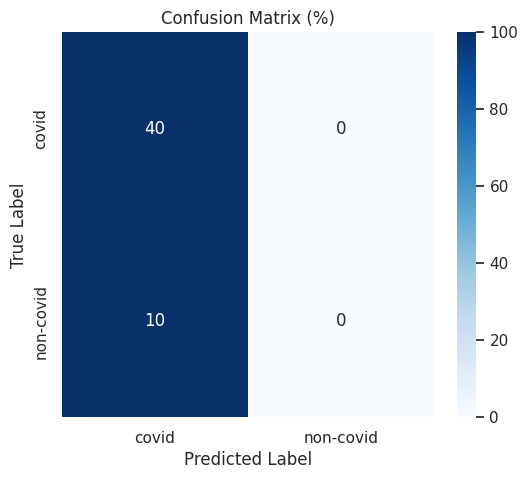

In [62]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(test_generator, verbose=1)
y_pred = (Y_pred > 0.5).astype(int).ravel()

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=cm, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


/tmp/ipython-input-2518783196.py:27: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2518783196.py:27: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


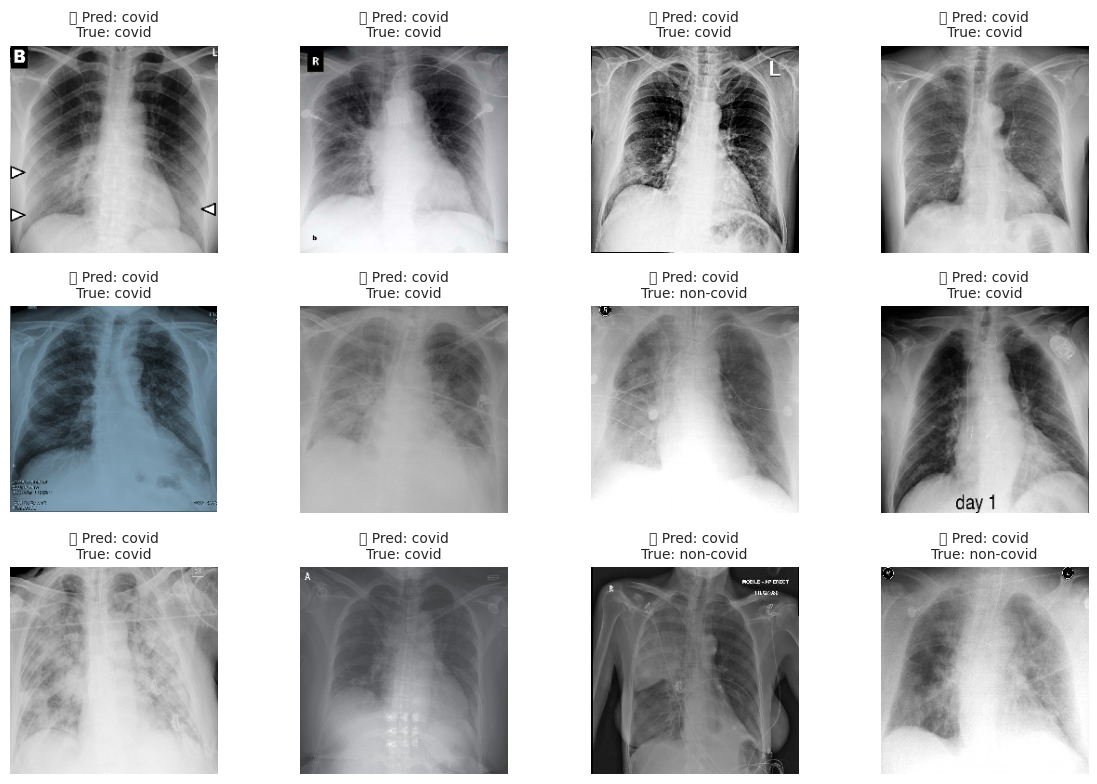

In [63]:
from tensorflow.keras.preprocessing import image

file_paths = test_generator.filepaths
sample_idxs = random.sample(range(len(file_paths)), 12)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_idxs):
    img_path = file_paths[idx]
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))[0][0]
    pred_label = class_labels[int(pred > 0.5)]
    true_label = class_labels[y_true[idx]]

    correctness = "✅" if pred_label == true_label else "❌"

    plt.subplot(3, 4, i + 1)
    plt.imshow(img_array)
    plt.title(f"{correctness} Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_318']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


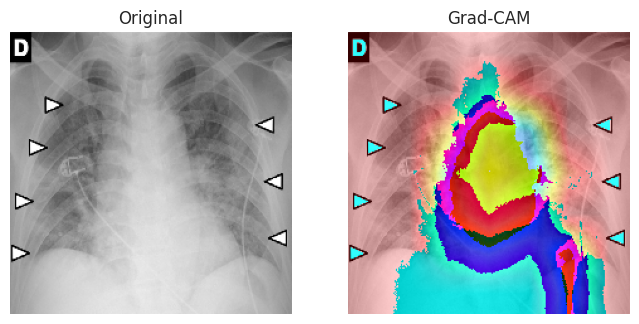

In [64]:
import tensorflow as tf
from tensorflow.keras import backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

last_conv_layer_name = "top_conv"

img_path = random.choice(file_paths)
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array_expanded = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)

import cv2
heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img_array * 255

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.uint8(superimposed_img))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

In [66]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_true, y_pred, target_names=['Non-COVID', 'COVID-19'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(3)
print(report_df)
report_df.to_csv("classification_report.csv")


              precision  recall  f1-score  support
Non-COVID          0.80     1.0     0.889     40.0
COVID-19           0.00     0.0     0.000     10.0
accuracy           0.80     0.8     0.800      0.8
macro avg          0.40     0.5     0.444     50.0
weighted avg       0.64     0.8     0.711     50.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
